/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730472618.348511      94 service.cc:145] XLA service 0x787884004590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730472618.348556      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/449 ━━━━━━━━━━━━━━━━━━━━ 1:22:09 11s/step - accuracy: 0.0781 - loss: 1.9614

I0000 00:00:1730472624.645181      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


449/449 ━━━━━━━━━━━━━━━━━━━━ 197s 415ms/step - accuracy: 0.2452 - loss: 1.8324 - val_accuracy: 0.2636 - val_loss: 1.7729
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 51s 97ms/step - accuracy: 0.2848 - loss: 1.7525 - val_accuracy: 0.3571 - val_loss: 1.6520
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 98ms/step - accuracy: 0.3465 - loss: 1.6592 - val_accuracy: 0.3774 - val_loss: 1.5866
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step - accuracy: 0.3838 - loss: 1.5852 - val_accuracy: 0.4166 - val_loss: 1.5144
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 98ms/step - accuracy: 0.4030 - loss: 1.5363 - val_accuracy: 0.4400 - val_loss: 1.4736
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 99ms/step - accuracy: 0.4292 - loss: 1.4823 - val_accuracy: 0.4535 - val_loss: 1.4277
Epoch 7/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 98ms/step - accuracy: 0.4467 - loss: 1.4463 - val_accuracy: 0.4748 - val_loss: 1.3890
Epoch 8/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 99ms/step - accuracy: 0.4656 - loss: 1.4151 - v

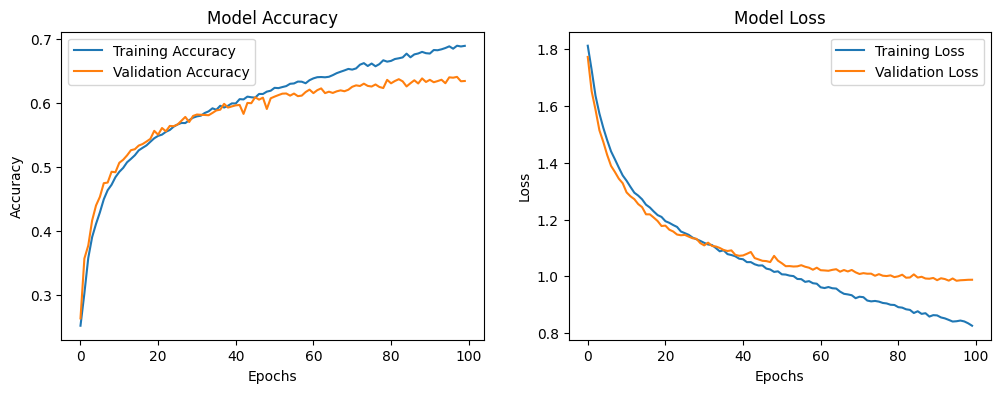

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step


<Figure size 1000x800 with 0 Axes>

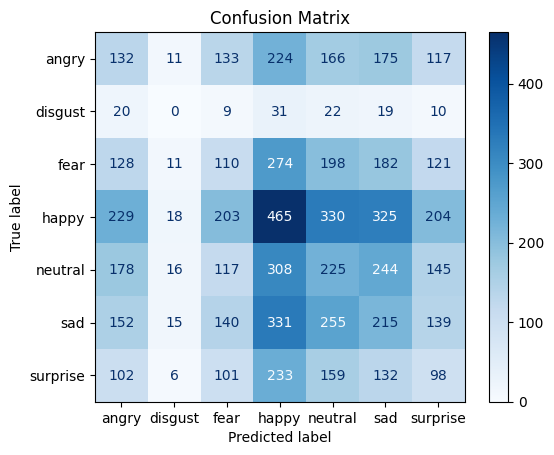

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Paths to training and test datasets
train_data_path = '/kaggle/input/fer2013/train/'
test_data_path = '/kaggle/input/fer2013/test/' 
epochs = 100

# Define the learning rate schedule
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=100000,  # Adjust based on dataset size
    decay_rate=0.96, 
    staircase=True
)

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),  # grayscale images
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25), 
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),  
    Dense(7, activation='softmax')  #  7 classes (happy,sad...)
])

# Compile the model with the new optimizer
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation for training
train_datagenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    shear_range=0.2,  # Added shear augmentation
    fill_mode='nearest'  # Fill mode for points outside the boundaries
)

val_datagenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    shear_range=0.2,  # Added shear augmentation
    fill_mode='nearest'  # Fill mode for points outside the boundaries
)

# Load the training data
train_data = train_datagenerator.flow_from_directory(
    train_data_path,  
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical'
)

# Load the validation data
val_data = val_datagenerator.flow_from_directory(
    test_data_path, 
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical'
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[early_stopping]
)

# Evaluate the model on validation data
loss, accuracy = model.evaluate(val_data)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

# Save the trained model as an H5 file
model.save('/kaggle/working/visual_trained_model.h5')  

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Step 1: Get predictions from the model
predictions = model.predict(val_data)
predicted_classes = np.argmax(predictions, axis=1)

# Step 2: Get true labels from the validation data generator
true_classes = val_data.classes  # This is available directly from the generator
class_labels = list(val_data.class_indices.keys())  # Get the class labels

# Step 3: Create the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()


